In [1]:
import warnings
import sys
sys.path.insert(0, '../src')

In [2]:
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/10884668/two-sample-kolmogorov-smirnov-test-in-python-scipy
from scipy.stats import ks_2samp

In [3]:
from felix_ml_tools import macgyver as mg

In [4]:
from utils import *
import config

In [5]:
warnings.filterwarnings('ignore')

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline 

# Hypothesis

Análise comparativa entre as cidades mais violentas e menos violentas

## Hypothesis 1

O nível de IDH é inversamente proporcional ao nível de violência nas cidades

- Hypothesis (1.2): Regiões com mais escolas públicas têm mais educação e, consequentemente, menor índice de violência
- Hypothesis (1.3): Famílias em cidades com alto grau de desemprego têm baixa renda / menor poder aquisitivo (ex: renda menor salário mínimo), o que faz fomentar alternativas ilegais para aumentar a renda e, consequentemente, conflitos com a polícia e a taxa de homicídios

Principais questões:
- É possível indentifiar as cidades mais violentas e menos violentas?
- Existe relação entre as características de diversaso fontes e as cidades mais/menos violentas?
- Existe diferença na população entre cidades mais/menos violentas?
- Existe diferença na taxa de homicidios entre cidades mais/menos violentas?
- Existe diferença na taxa de homicidios de pessoas com/sem ocupação entre cidades mais/menos violentas?
- Existe diferença na taxa de empregabilidade (formal/CLT) entre cidades mais/menos violentas?
- Existe diferença no PIB per capita entre cidades mais/menos violentas?
- Existe diferença nas atividades economicas entre cidades mais/menos violentas? (cnae, cbo)
- Existe diferença na quantidade de escolas?
- Existe diferença na quantidade de hospitais?

# Intro

Ingestão de recorte de dados conforme população-alvo

In [6]:
target_col = 'violento'

municipio_rotulados = pd.read_parquet('../data/handled/municipios_features_labeled.parquet')

top_municipios_mais_violentos = municipio_rotulados[municipio_rotulados[target_col] == True]
top_municipios_menos_violentos = municipio_rotulados[municipio_rotulados[target_col] == False]

inspect(municipio_rotulados);

shape: (80, 43)
columns: ['uf', 'nomeMunicipio', 'populacaoEstimada', 'partSetorUrbano', 'mediaMoradoresDomicilios', 'mediaRendaMensalMoradores', 'pibPerCapita', 'part_funcionarios_populacao1k', 'part_homicidios_com_ocupacao', 'part_homicidios_populacao1k', 'nivelHomicidiosPopulacao1k', 'part_empresas_publsoci_populacao1k', 'part_empresas_agropecu_populacao1k', 'part_empresas_alojalim_populacao1k', 'part_empresas_artcules_populacao1k', 'part_empresas_admicomp_populacao1k', 'part_empresas_ongassoc_populacao1k', 'part_empresas_finanseg_populacao1k', 'part_empresas_imobilia_populacao1k', 'part_empresas_procient_populacao1k', 'part_empresas_automoto_populacao1k', 'part_empresas_construc_populacao1k', 'part_empresas_educacao_populacao1k', 'part_empresas_eletrgas_populacao1k', 'part_empresas_indtrans_populacao1k', 'part_empresas_infocomu_populacao1k', 'part_empresas_outrserv_populacao1k', 'part_empresas_saudsoci_populacao1k', 'part_empresas_transpor_populacao1k', 'part_empresas_aguaesgo_popu

,uf,nomeMunicipio,populacaoEstimada,partSetorUrbano,mediaMoradoresDomicilios,mediaRendaMensalMoradores,pibPerCapita,part_funcionarios_populacao1k,part_homicidios_com_ocupacao,part_homicidios_populacao1k,nivelHomicidiosPopulacao1k,part_empresas_publsoci_populacao1k,part_empresas_agropecu_populacao1k,part_empresas_alojalim_populacao1k,part_empresas_artcules_populacao1k,part_empresas_admicomp_populacao1k,part_empresas_ongassoc_populacao1k,part_empresas_finanseg_populacao1k,part_empresas_imobilia_populacao1k,part_empresas_procient_populacao1k,part_empresas_automoto_populacao1k,part_empresas_construc_populacao1k,part_empresas_educacao_populacao1k,part_empresas_eletrgas_populacao1k,part_empresas_indtrans_populacao1k,part_empresas_infocomu_populacao1k,part_empresas_outrserv_populacao1k,part_empresas_saudsoci_populacao1k,part_empresas_transpor_populacao1k,part_empresas_aguaesgo_populacao1k,part_empresas_indextra_populacao1k,part_empresas_domestic_populacao1k,part_empresas_internac_populacao1k,aprvEfTotal,reprvEfTotal,abdEfTotal,aprvEmTotal,reprvEmTotal,abdEmTotal,aprvEmNSeriado,reprvEmNSeriado,abdEmNSeriado,violento
964,CE,Ibicuitinga,12525.000,0.474,3.551,319.241,7524,59.401,0.700,0.798,alto,0.639,0.399,2.715,1.118,4.471,6.707,0.160,0.319,2.954,27.784,2.475,1.597,0.160,5.509,1.277,3.114,0.319,2.315,1.437,0.000,0.080,0.000,95.700,3.600,0.700,89.100,10.300,0.600,0.000,0.000,0.000,True
976,CE,Itaitinga,37980.000,0.958,3.704,478.079,16879,114.323,0.773,1.159,muito alto,0.263,0.685,8.346,1.527,9.821,4.028,1.159,2.686,5.345,42.022,10.927,3.186,0.079,16.851,2.054,7.267,0.764,8.189,2.370,0.737,0.895,0.000,91.600,7.100,1.300,87.900,3.900,8.200,0.000,0.000,0.000,True
1019,CE,Pacoti,12261.000,0.286,3.887,460.302,13845,52.361,0.625,0.652,alto,1.305,1.387,7.911,1.876,4.975,8.401,0.408,0.408,3.344,30.829,3.099,3.018,0.082,6.769,1.794,3.833,0.652,1.223,0.163,0.245,0.000,0.000,93.200,5.800,1.000,87.100,4.800,8.100,0.000,0.000,0.000,True
1022,CE,Palmácia,13322.000,0.429,3.846,472.656,7676,46.089,0.444,0.676,alto,0.826,0.676,3.003,1.126,3.228,6.831,0.676,0.225,1.501,19.442,1.952,1.651,0.075,4.654,0.901,2.252,0.375,1.201,0.150,0.000,0.075,0.000,98.200,1.300,0.500,95.700,3.300,1.000,0.000,0.000,0.000,True
1072,CE,Varjota,18420.000,0.800,3.572,524.964,13911,77.742,0.167,0.651,alto,0.489,0.869,6.895,1.900,6.515,5.483,0.326,0.434,3.366,41.965,4.669,2.063,0.163,9.446,2.606,5.755,1.357,3.800,1.574,0.434,0.109,0.000,95.900,2.600,1.500,90.600,1.200,8.200,0.000,0.000,0.000,True


## Ranking

Qual municipio tem maior taxa de homícios por 1000 habitantes?

In [7]:
municipio_rotulados.sort_values(by='part_homicidios_populacao1k', ascending=False).head(5)

,uf,nomeMunicipio,populacaoEstimada,partSetorUrbano,mediaMoradoresDomicilios,mediaRendaMensalMoradores,pibPerCapita,part_funcionarios_populacao1k,part_homicidios_com_ocupacao,part_homicidios_populacao1k,nivelHomicidiosPopulacao1k,part_empresas_publsoci_populacao1k,part_empresas_agropecu_populacao1k,part_empresas_alojalim_populacao1k,part_empresas_artcules_populacao1k,part_empresas_admicomp_populacao1k,part_empresas_ongassoc_populacao1k,part_empresas_finanseg_populacao1k,part_empresas_imobilia_populacao1k,part_empresas_procient_populacao1k,part_empresas_automoto_populacao1k,part_empresas_construc_populacao1k,part_empresas_educacao_populacao1k,part_empresas_eletrgas_populacao1k,part_empresas_indtrans_populacao1k,part_empresas_infocomu_populacao1k,part_empresas_outrserv_populacao1k,part_empresas_saudsoci_populacao1k,part_empresas_transpor_populacao1k,part_empresas_aguaesgo_populacao1k,part_empresas_indextra_populacao1k,part_empresas_domestic_populacao1k,part_empresas_internac_populacao1k,aprvEfTotal,reprvEfTotal,abdEfTotal,aprvEmTotal,reprvEmTotal,abdEmTotal,aprvEmNSeriado,reprvEmNSeriado,abdEmNSeriado,violento
1201,RN,São Bento do Norte,2747.000,0.222,3.812,424.344,69005,194.394,0.000,1.820,muito alto,2.548,4.368,10.557,0.728,6.189,20.750,0.364,0.728,3.640,29.487,6.917,3.640,8.737,9.465,1.092,3.276,0.364,2.184,1.820,0.000,0.364,0.000,81.200,15.000,3.800,61.400,16.900,21.700,0.000,0.000,0.000,True
1868,BA,Barro Preto,5591.000,0.400,3.255,502.927,9643,86.210,0.000,1.431,muito alto,1.431,2.683,4.114,1.431,4.293,14.309,0.179,0.179,3.219,28.439,3.398,1.252,0.000,6.260,1.431,4.293,1.073,2.325,0.715,0.000,0.179,0.000,83.400,14.300,2.300,91.500,4.300,4.200,0.000,0.000,0.000,True
976,CE,Itaitinga,37980.000,0.958,3.704,478.079,16879,114.323,0.773,1.159,muito alto,0.263,0.685,8.346,1.527,9.821,4.028,1.159,2.686,5.345,42.022,10.927,3.186,0.079,16.851,2.054,7.267,0.764,8.189,2.370,0.737,0.895,0.000,91.600,7.100,1.300,87.900,3.900,8.200,0.000,0.000,0.000,True
2237,BA,Vera Cruz,43223.000,0.911,3.036,811.485,11752,85.163,0.522,1.064,muito alto,0.347,0.625,13.303,2.013,8.792,7.380,0.648,0.972,4.141,45.138,6.871,2.961,0.023,9.000,1.689,5.113,1.203,4.951,0.671,0.578,0.162,0.000,81.500,15.300,3.200,55.600,35.300,9.100,71.300,28.700,0.000,True
2186,BA,São José da Vitória,5657.000,0.467,3.290,401.126,8119,82.729,0.167,1.061,muito alto,1.237,1.237,4.066,1.414,3.359,7.424,0.707,0.354,1.768,29.874,3.712,1.944,0.000,3.535,0.530,4.066,0.707,1.944,0.177,0.000,0.177,0.000,83.400,12.100,4.500,66.900,16.900,16.200,0.000,0.000,0.000,True


## Questões

**Existe relação entre as características de diversaso fontes e as cidades mais/menos violentas?**

interval columns not set, guessing: ['populacaoEstimada', 'partSetorUrbano', 'mediaMoradoresDomicilios', 'mediaRendaMensalMoradores', 'pibPerCapita', 'part_funcionarios_populacao1k', 'part_homicidios_com_ocupacao', 'part_homicidios_populacao1k', 'part_empresas_publsoci_populacao1k', 'part_empresas_agropecu_populacao1k', 'part_empresas_alojalim_populacao1k', 'part_empresas_artcules_populacao1k', 'part_empresas_admicomp_populacao1k', 'part_empresas_ongassoc_populacao1k', 'part_empresas_finanseg_populacao1k', 'part_empresas_imobilia_populacao1k', 'part_empresas_procient_populacao1k', 'part_empresas_automoto_populacao1k', 'part_empresas_construc_populacao1k', 'part_empresas_educacao_populacao1k', 'part_empresas_eletrgas_populacao1k', 'part_empresas_indtrans_populacao1k', 'part_empresas_infocomu_populacao1k', 'part_empresas_outrserv_populacao1k', 'part_empresas_saudsoci_populacao1k', 'part_empresas_transpor_populacao1k', 'part_empresas_aguaesgo_populacao1k', 'part_empresas_indextra_populaca

Text(203.09375, 0.5, 'target')

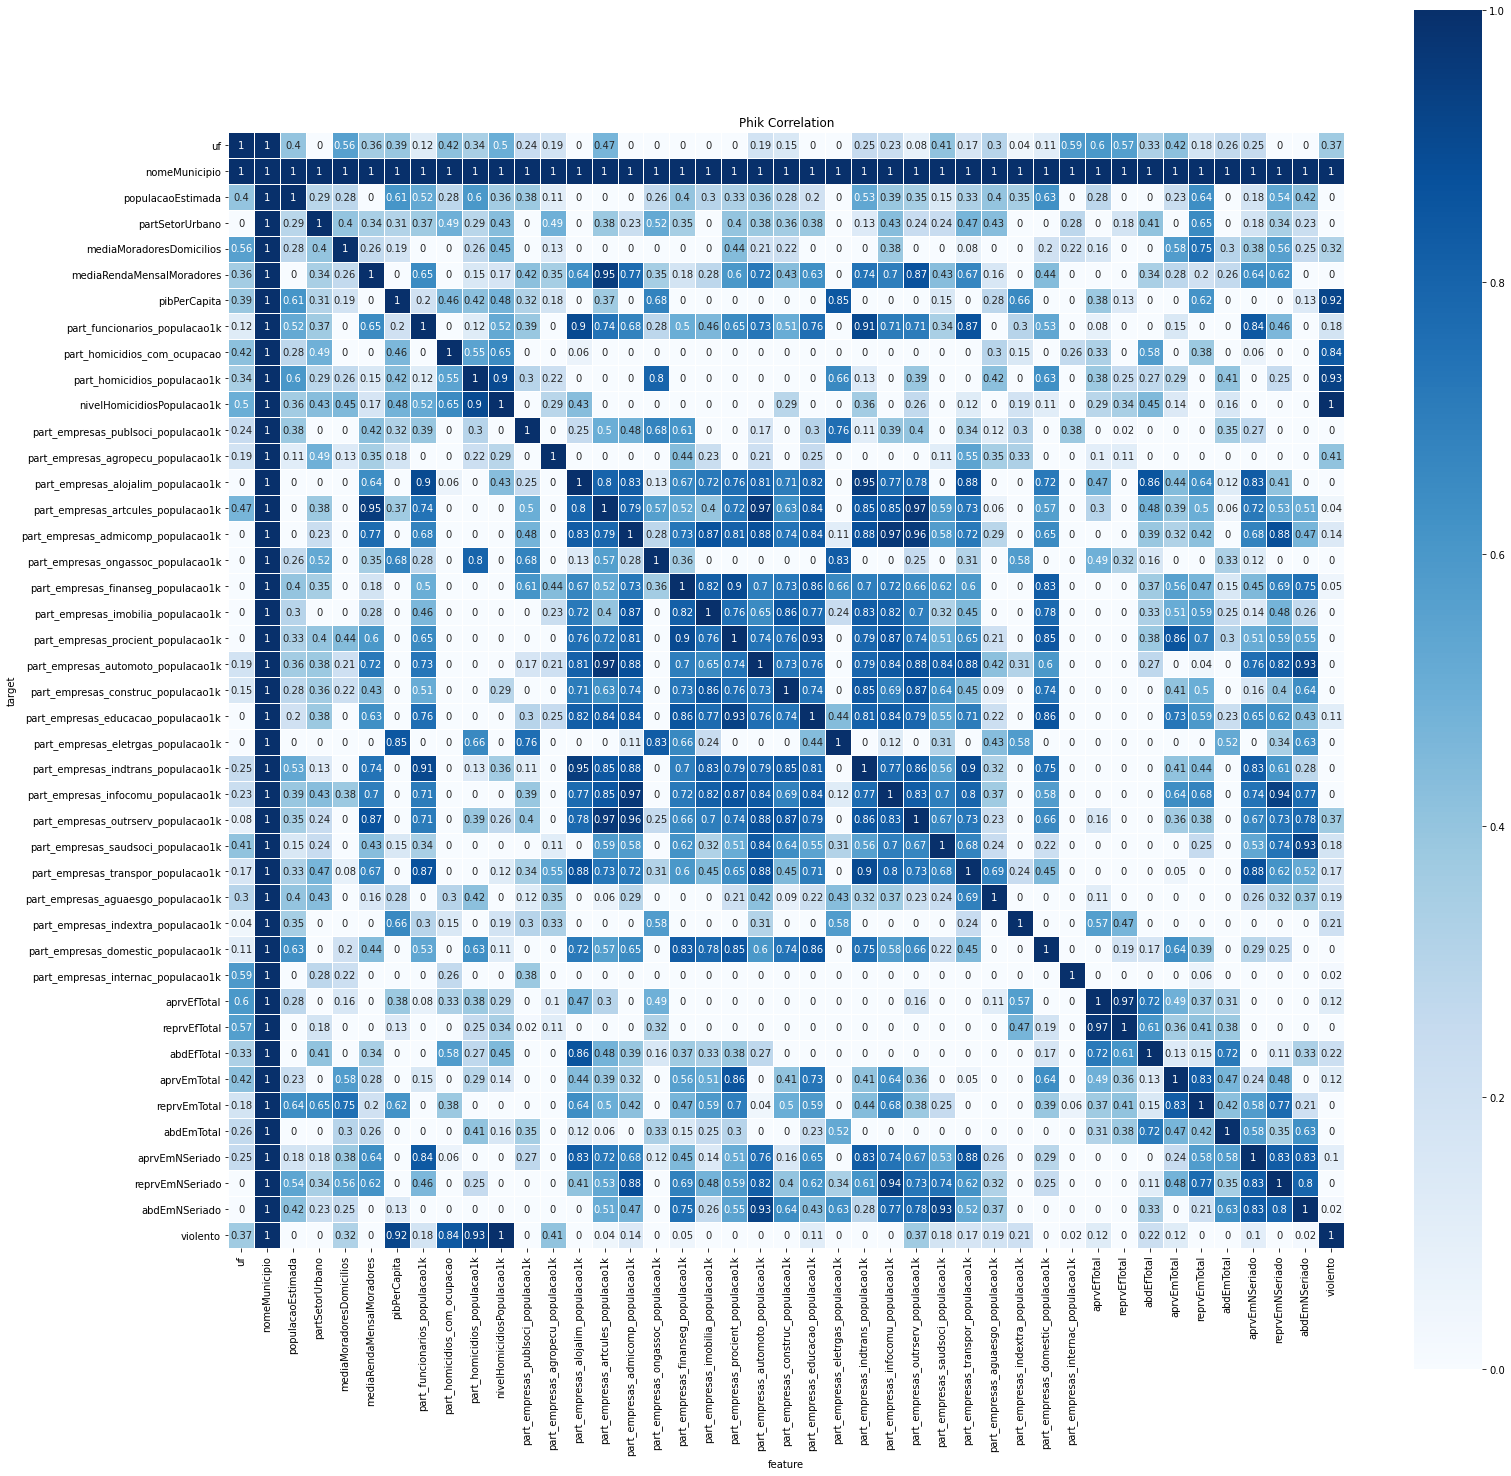

In [8]:
from phik.report import plot_correlation_matrix

tst = municipio_rotulados.phik_matrix()
# tst = municipio_features_slice.phik_matrix()

fig, ax = plt.subplots(figsize=(25, 25))

ax = sns.heatmap(
    tst.apply(lambda x: x.round(2)),
    cmap="Blues",
    linewidths=0.5,
    square=True,
    annot=True,
    fmt='g'
)

ax.set_title("Phik Correlation")
ax.set_xlabel("feature")
ax.set_ylabel("target")

interval columns not set, guessing: ['populacaoEstimada', 'partSetorUrbano', 'mediaMoradoresDomicilios', 'mediaRendaMensalMoradores', 'pibPerCapita', 'part_funcionarios_populacao1k', 'part_homicidios_com_ocupacao', 'part_homicidios_populacao1k', 'part_empresas_publsoci_populacao1k', 'part_empresas_agropecu_populacao1k', 'part_empresas_alojalim_populacao1k', 'part_empresas_artcules_populacao1k', 'part_empresas_admicomp_populacao1k', 'part_empresas_ongassoc_populacao1k', 'part_empresas_finanseg_populacao1k', 'part_empresas_imobilia_populacao1k', 'part_empresas_procient_populacao1k', 'part_empresas_automoto_populacao1k', 'part_empresas_construc_populacao1k', 'part_empresas_educacao_populacao1k', 'part_empresas_eletrgas_populacao1k', 'part_empresas_indtrans_populacao1k', 'part_empresas_infocomu_populacao1k', 'part_empresas_outrserv_populacao1k', 'part_empresas_saudsoci_populacao1k', 'part_empresas_transpor_populacao1k', 'part_empresas_aguaesgo_populacao1k', 'part_empresas_indextra_populaca

Text(203.09375, 0.5, 'target')

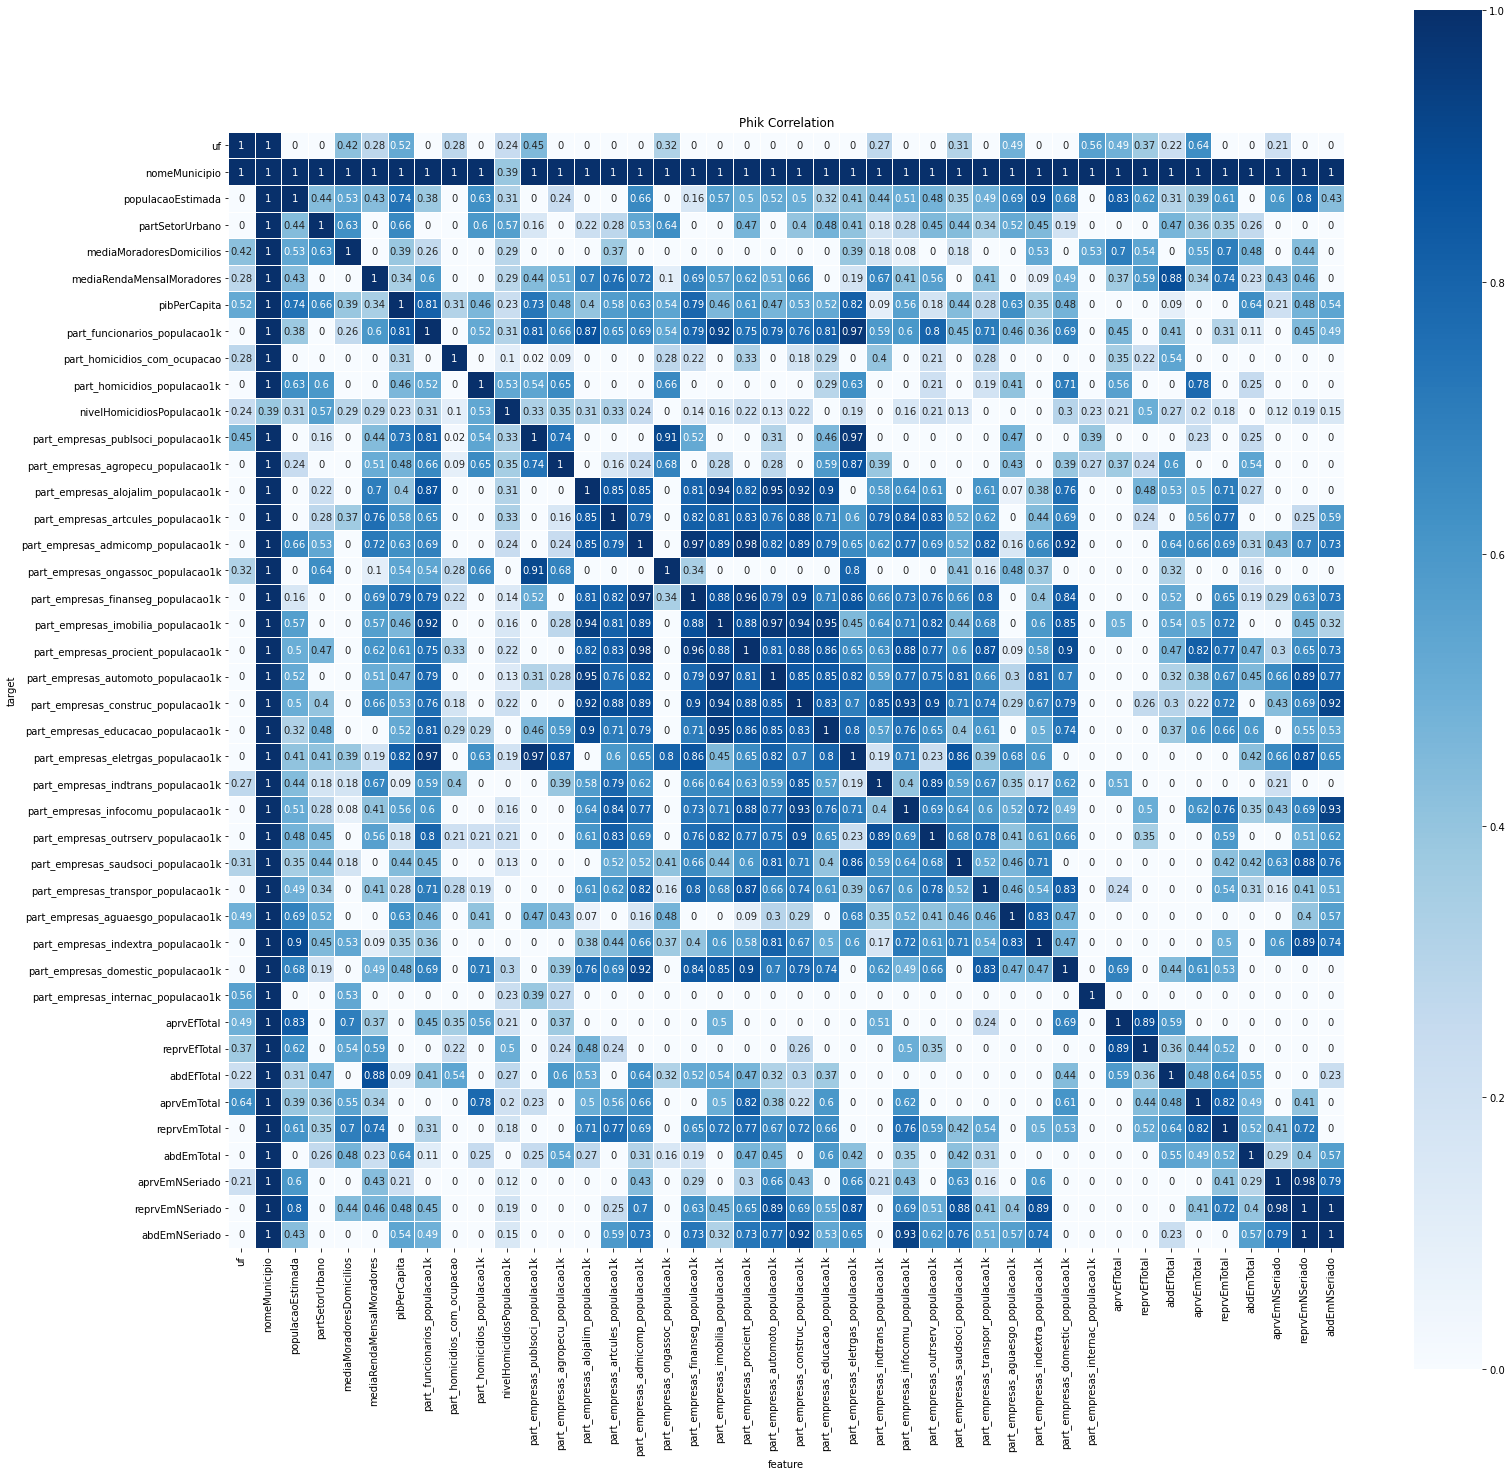

In [9]:
from phik.report import plot_correlation_matrix

tst = top_municipios_mais_violentos.phik_matrix()
# tst = municipio_features_slice.phik_matrix()

fig, ax = plt.subplots(figsize=(25, 25))

ax = sns.heatmap(
    tst.apply(lambda x: x.round(2)),
    cmap="Blues",
    linewidths=0.5,
    square=True,
    annot=True,
    fmt='g'
)

ax.set_title("Phik Correlation")
ax.set_xlabel("feature")
ax.set_ylabel("target")

interval columns not set, guessing: ['populacaoEstimada', 'partSetorUrbano', 'mediaMoradoresDomicilios', 'mediaRendaMensalMoradores', 'pibPerCapita', 'part_funcionarios_populacao1k', 'part_homicidios_com_ocupacao', 'part_homicidios_populacao1k', 'part_empresas_publsoci_populacao1k', 'part_empresas_agropecu_populacao1k', 'part_empresas_alojalim_populacao1k', 'part_empresas_artcules_populacao1k', 'part_empresas_admicomp_populacao1k', 'part_empresas_ongassoc_populacao1k', 'part_empresas_finanseg_populacao1k', 'part_empresas_imobilia_populacao1k', 'part_empresas_procient_populacao1k', 'part_empresas_automoto_populacao1k', 'part_empresas_construc_populacao1k', 'part_empresas_educacao_populacao1k', 'part_empresas_eletrgas_populacao1k', 'part_empresas_indtrans_populacao1k', 'part_empresas_infocomu_populacao1k', 'part_empresas_outrserv_populacao1k', 'part_empresas_saudsoci_populacao1k', 'part_empresas_transpor_populacao1k', 'part_empresas_aguaesgo_populacao1k', 'part_empresas_indextra_populaca

Text(203.09375, 0.5, 'target')

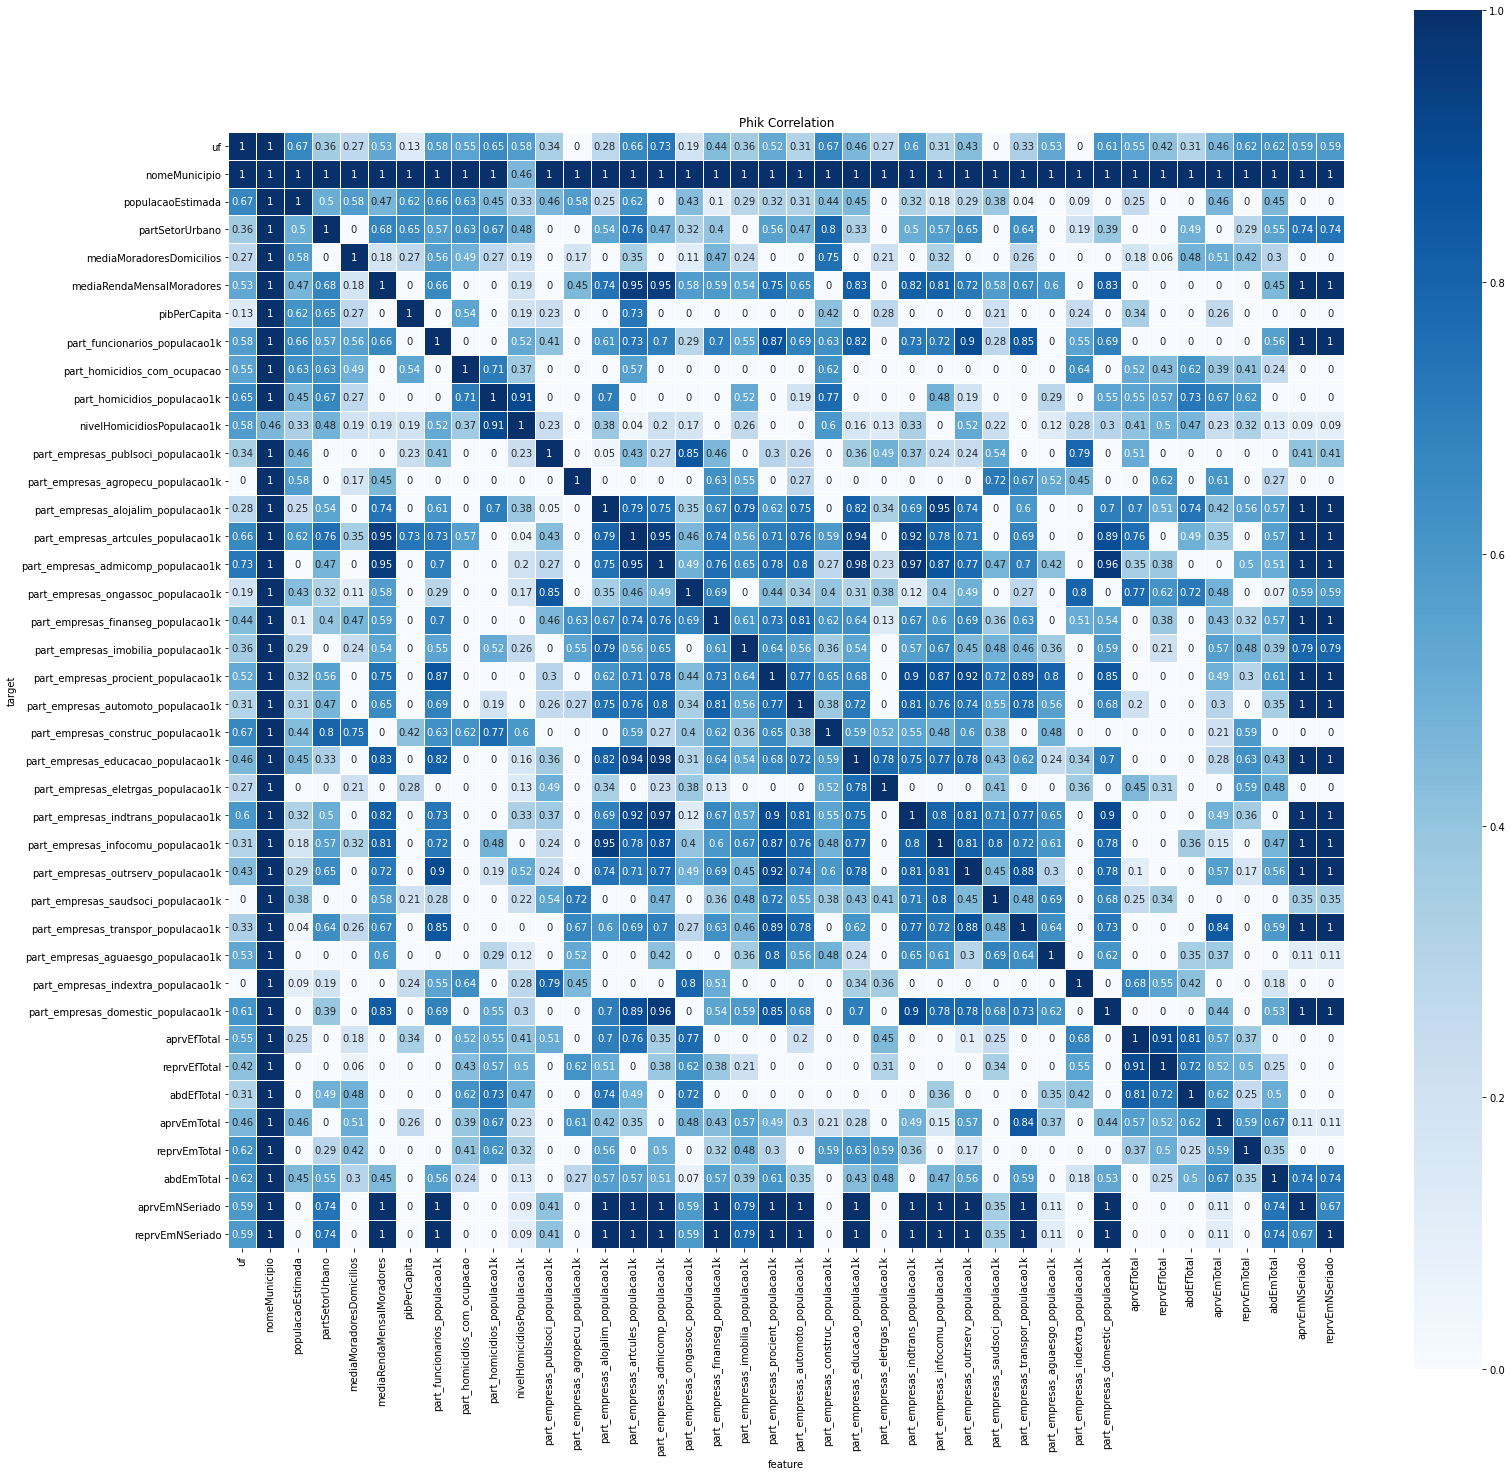

In [10]:
from phik.report import plot_correlation_matrix

tst = top_municipios_menos_violentos.phik_matrix()
# tst = municipio_features_slice.phik_matrix()

fig, ax = plt.subplots(figsize=(25, 25))

ax = sns.heatmap(
    tst.apply(lambda x: x.round(2)),
    cmap="Blues",
    linewidths=0.5,
    square=True,
    annot=True,
    fmt='g'
)

ax.set_title("Phik Correlation")
ax.set_xlabel("feature")
ax.set_ylabel("target")

**Existe diferença na população entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 16336.525
	CI (13133.07875, 19407.6375)
top_municipios_menos_violentos kpis:
	avg 16367.825
	CI (13026.555625, 20076.441250000003)
KS-test KstestResult(statistic=0.125, pvalue=0.9188052214121167)


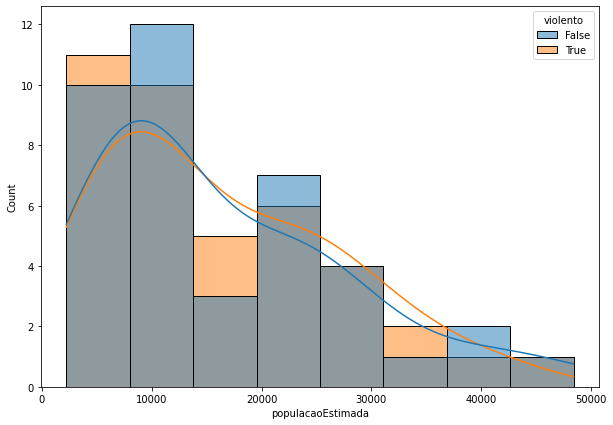

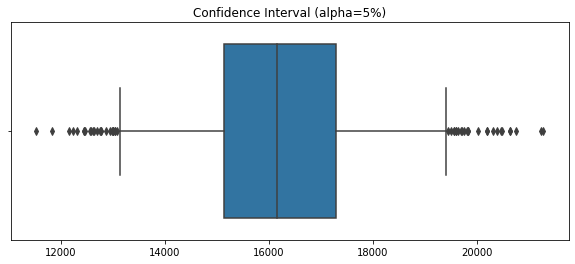

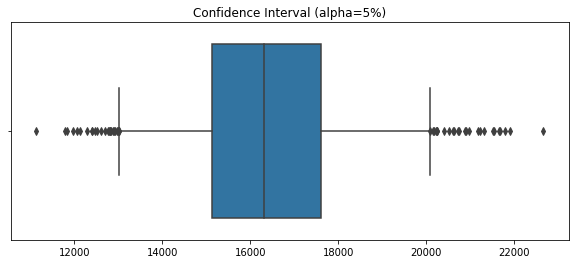

In [11]:
explainable_col = 'populacaoEstimada'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Como esperado, não existe diferença populacional significante entre cidades mais/menos violentas, pois foi realizada uma seleção balanceada dos dados para análises comparativas posteriores.

**Existe diferença na taxa de homicídios entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 0.789043317338713
	CI (0.7240317339953298, 0.8775272151054448)
top_municipios_menos_violentos kpis:
	avg 0.16270636270446218
	CI (0.11401782326296668, 0.21527583445378856)
KS-test KstestResult(statistic=1.0, pvalue=1.860340365603627e-23)


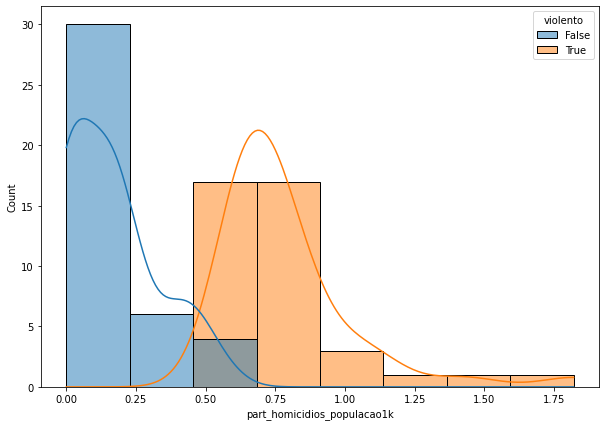

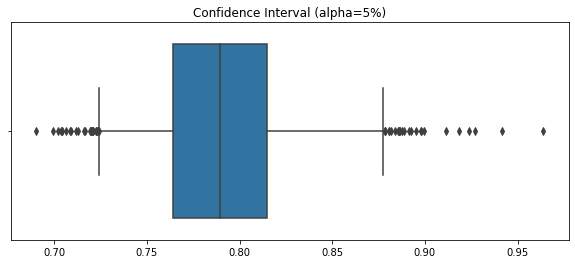

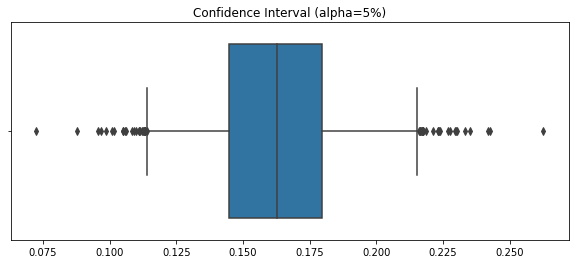

In [12]:
explainable_col = 'part_homicidios_populacao1k'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Como esperado, existe diferença na taxa de homicídios entre cidades mais/menos violentas devido seleção da população-alvo.
- Em cidades mais violentas, a média é de 1 homicídio por 1000 habitantes. A quantidade de homicídios chegou a **2 para cada mil habitantes** em algumas cidades
- Em relação as cidades menos violentas, a quantidade de homicídios é quase zero

**Existe diferença na taxa de homicídios de pessoas com/sem ocupação entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 0.3756409805028731
	CI (0.30333772888272564, 0.4517400731834236)
top_municipios_menos_violentos kpis:
	avg 0.3002248023715415
	CI (0.18109490577357426, 0.41792346308582723)
KS-test KstestResult(statistic=0.475, pvalue=0.00018791118070078278)


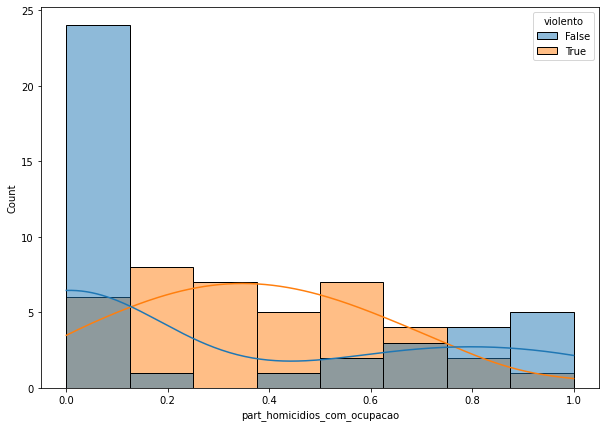

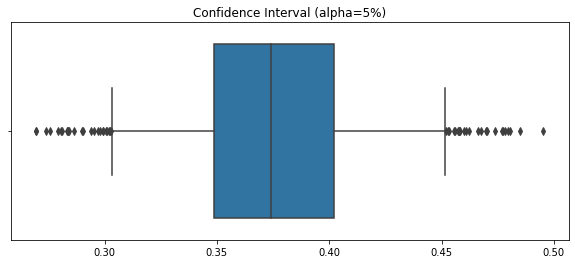

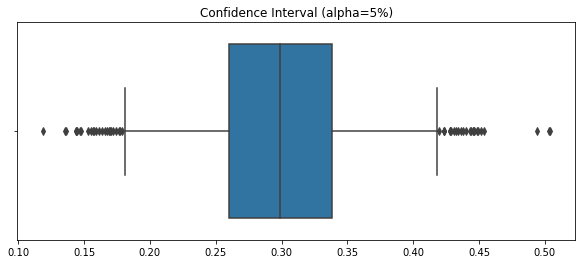

In [13]:
explainable_col = 'part_homicidios_com_ocupacao'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença de taxa de homicídios de pessoas com/sem ocupação entre cidades mais/menos violentas
- Em cidades mais violentas, a taxa média de homicídios de pessoas ocupadas (SIM) é de 38%. Pode variar de 30% até **45%** em algumas cidades.
- Em cidades menos violentas, a taxa média de homicídios de pessoas ocupadas (SIM) é de 30%. Varia de **18%**  até 42%.

**Existe diferença na taxa de empregabilidade (formal/CLT) entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 85.32353909742105
	CI (72.96291808190345, 100.26114857896792)
top_municipios_menos_violentos kpis:
	avg 125.74087599811392
	CI (99.8933616730761, 162.18557059771885)
KS-test KstestResult(statistic=0.375, pvalue=0.006760732303569208)


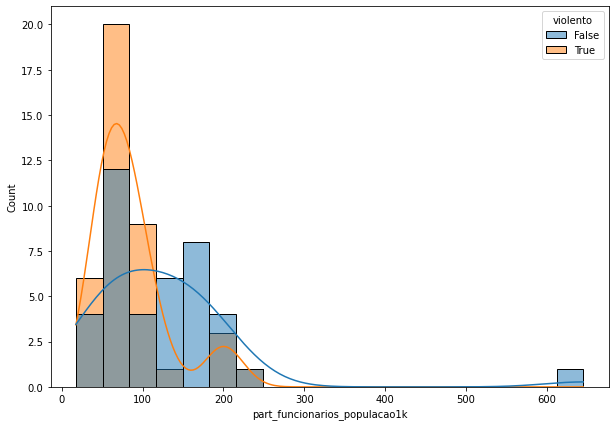

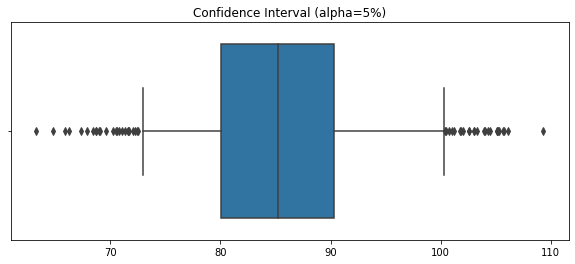

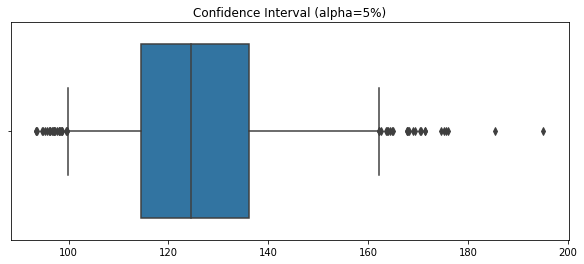

In [14]:
explainable_col = 'part_funcionarios_populacao1k'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença de empregabilidade entre cidades violentas e não violentas
- A empregabilidade em cidades mais violentas é menor (média de 85 a cada 1000 hab.)
    - A cada mil habitantes entre 73-100 pessoas possuem emprego formal
- A empregabilidade em cidades menos violentas é maior (média de 126 a cada 1000 hab.)
    - A cada mil habitantes entre 100-162 pessoas possuem emprego formal
- A empregabilidade é **32% maior em cidades menos violentas**

**Existe diferença no PIB per capita entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 15989.0
	CI (11905.080625, 21402.317499999997)
top_municipios_menos_violentos kpis:
	avg 56851.0
	CI (46959.894374999996, 71538.896875)
KS-test KstestResult(statistic=0.875, pvalue=4.472261215455704e-16)


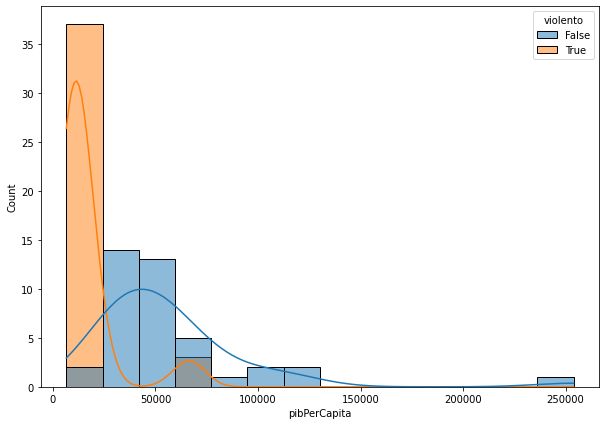

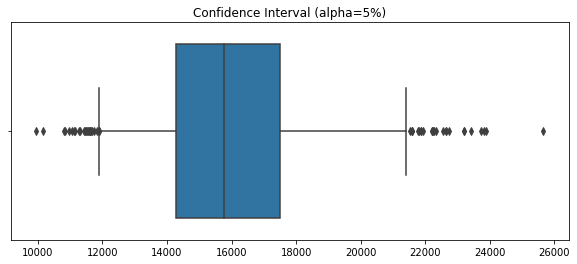

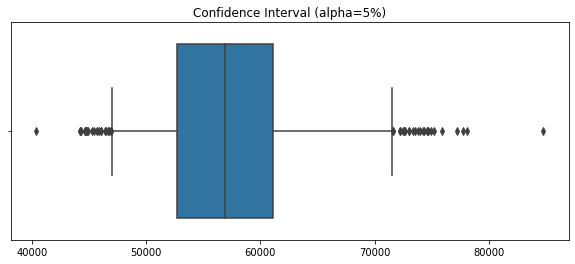

In [15]:
explainable_col = 'pibPerCapita'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe uma diferença significante muito grande do PIB entre cidades mais/menos violentas
- O PIB em cidades mais violentas é menor (média de R \$ 16000 por pessoa)
- O PIB em cidades menos violentas é maior (média de R \$ 57000 por pessoa)
- O PIB é **72% maior em cidades menos violentas**

**Existe diferença no mediaRendaMensalMoradores entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 557.6687509217509
	CI (517.6056810014957, 598.7942623779892)
top_municipios_menos_violentos kpis:
	avg 599.6174450912584
	CI (526.7985864869032, 687.8824396408053)
KS-test KstestResult(statistic=0.175, pvalue=0.5786001416508443)


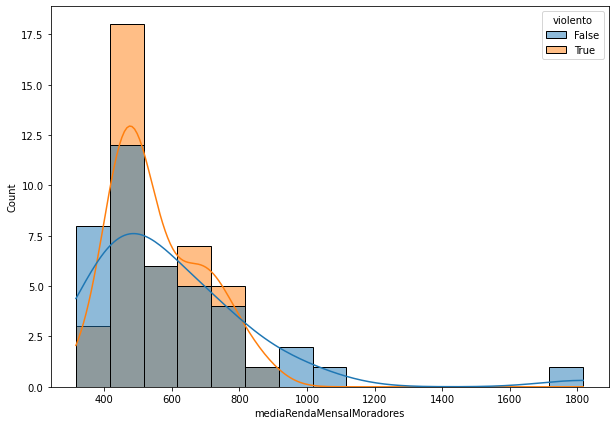

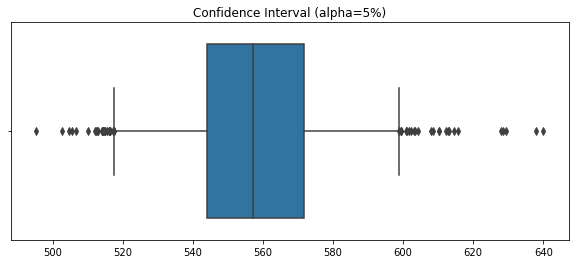

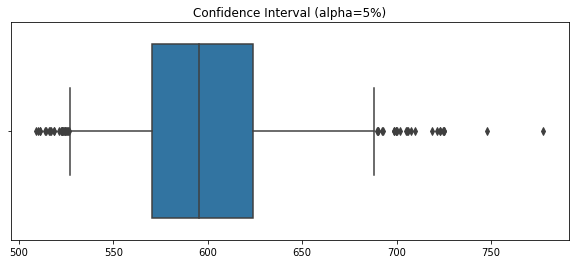

In [16]:
explainable_col = 'mediaRendaMensalMoradores'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença significante na renda média informada dos moradores (2010) entre cidades mais/menos violentas
- Moradores de cidades mais violentas ganham em média R \\$ 558 por mês. Varia de R \\$ 518-600
- No entando, a diferença é baixa. Moradores de cidades menos violentas **ganham em média R \\$ 83 reais a mais**. Varia de R\\$ 527-687

**Existe diferença no partSetorUrbano entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 0.5606095993779749
	CI (0.4892932059832743, 0.6266704281005419)
top_municipios_menos_violentos kpis:
	avg 0.47484255362971883
	CI (0.40501085843534024, 0.5417383012530052)
KS-test KstestResult(statistic=0.2, pvalue=0.404587405685253)


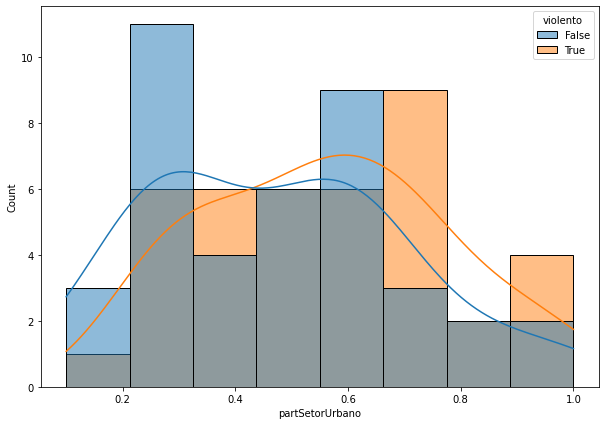

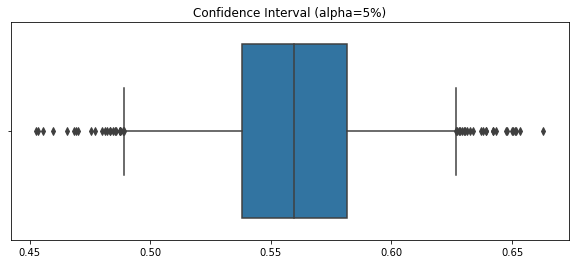

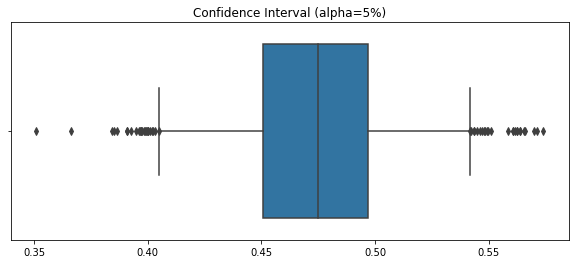

In [17]:
explainable_col = 'partSetorUrbano'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Não existe diferença significante na taxa de urbaniação (setores censitários) entre cidades mais/menos violentas
- No geral, cidades mais violentas são um pouco mais urbanizadas (56% contra 47%)

**Existe diferença na partipação de empresas  por divisão econômica entre cidades mais/menos violentas?**

In [18]:
explainable_cols = [
    'part_empresas_publsoci_populacao1k',
    'part_empresas_agropecu_populacao1k',
    'part_empresas_alojalim_populacao1k',
    'part_empresas_artcules_populacao1k',
    'part_empresas_admicomp_populacao1k',
    'part_empresas_ongassoc_populacao1k',
    'part_empresas_finanseg_populacao1k',
    'part_empresas_imobilia_populacao1k',
    'part_empresas_procient_populacao1k',
    'part_empresas_automoto_populacao1k',
    'part_empresas_construc_populacao1k',
    'part_empresas_educacao_populacao1k',
    'part_empresas_eletrgas_populacao1k',
    'part_empresas_indtrans_populacao1k',
    'part_empresas_infocomu_populacao1k',
    'part_empresas_outrserv_populacao1k',
    'part_empresas_saudsoci_populacao1k',
    'part_empresas_transpor_populacao1k',
    'part_empresas_aguaesgo_populacao1k',
    'part_empresas_indextra_populacao1k',
    'part_empresas_domestic_populacao1k',
    'part_empresas_internac_populacao1k'
]

# verificando se existe diferença entre municipios considerando diferentes atividades economicas

for explainable_col in explainable_cols:
    ks_test = ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col])[1]

    if ks_test < 0.05:
        print(f'Existe na part. de empresas da divisão econ. {explainable_col}. p-value = {ks_test} < 5%')

Existe na part. de empresas da divisão econ. part_empresas_agropecu_populacao1k. p-value = 0.003018184077228396 < 5%
Existe na part. de empresas da divisão econ. part_empresas_eletrgas_populacao1k. p-value = 0.01430154804770646 < 5%
Existe na part. de empresas da divisão econ. part_empresas_transpor_populacao1k. p-value = 0.01430154804770646 < 5%
Existe na part. de empresas da divisão econ. part_empresas_indextra_populacao1k. p-value = 0.0005039436209702519 < 5%


top_municipios_mais_violentos kpis:
	avg 1.2418330875503227
	CI (0.9939824589975252, 1.5473622753631022)
top_municipios_menos_violentos kpis:
	avg 2.935406391453052
	CI (2.1733574300690393, 3.8428286446100186)
KS-test KstestResult(statistic=0.4, pvalue=0.003018184077228396)


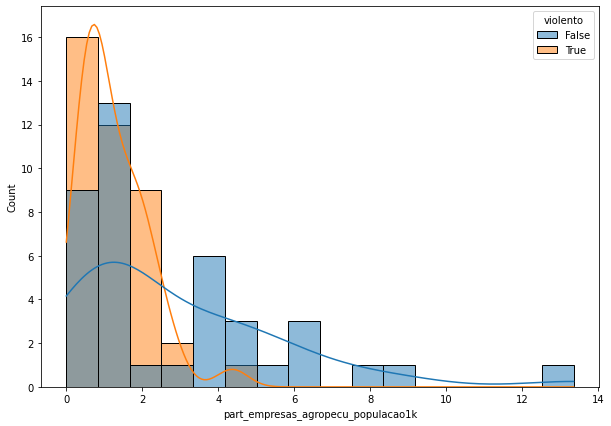

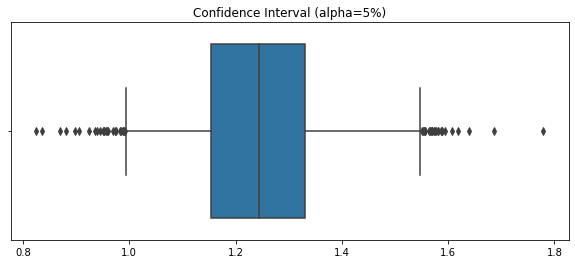

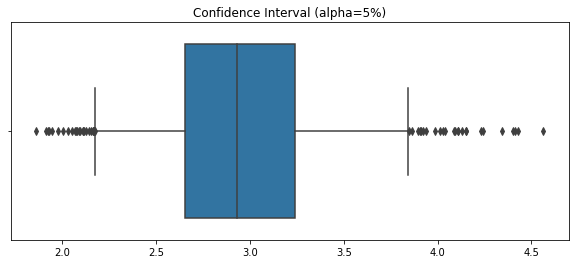

In [19]:
explainable_col = 'part_empresas_agropecu_populacao1k'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença significante da quantidade de empresas da divisão econômica AGROPECU entre cidades mais/menos violentas
- No geral existem 3 empresas nessa divisão a cada mil hab. para cidades menos violentas
- Para cidades mais violentas, existe em média 1 empresa nessa divisão a cada mil hab
- Obs: `agropecu` == 'AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PESCA E AQÜICULTURA''AGRICULTURA, PECUÁRIA, PRODUÇÃO FLORESTAL, PESCA E AQÜICULTURA'

top_municipios_mais_violentos kpis:
	avg 0.48727166871614386
	CI (0.046198224535131414, 1.1391669481398743)
top_municipios_menos_violentos kpis:
	avg 0.44961702250001545
	CI (0.20805619870836148, 0.7562796315466012)
KS-test KstestResult(statistic=0.35, pvalue=0.01430154804770646)


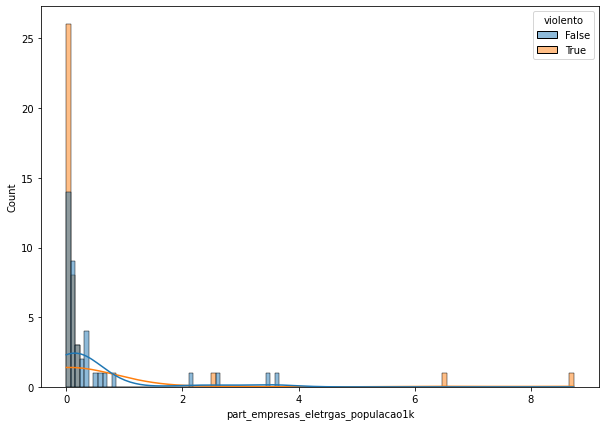

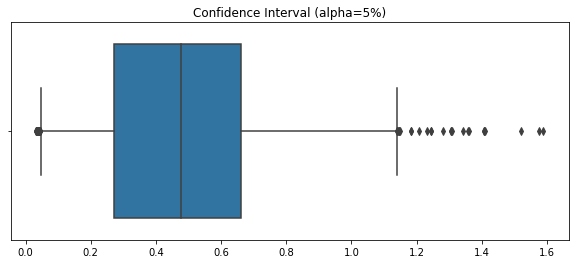

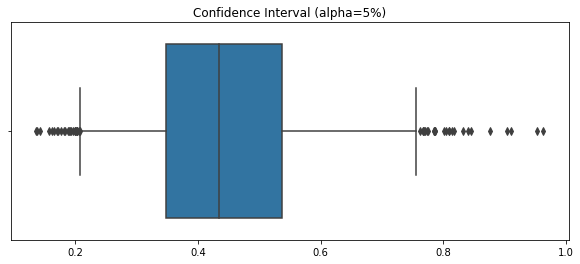

In [20]:
explainable_col = 'part_empresas_eletrgas_populacao1k'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Apesar de existir diferença significante, **a diferença da quantidade de empresas é baixa** na divisão econômica ELETRGAS entre cidades mais/menos violentas
- Obs: `eletrgas` ==  'ELETRICIDADE E GÁS'

top_municipios_mais_violentos kpis:
	avg 4.170342387546766
	CI (3.3408325287032214, 5.096986136688097)
top_municipios_menos_violentos kpis:
	avg 7.1739119264493425
	CI (5.412356952718892, 9.7095933008729)
KS-test KstestResult(statistic=0.35, pvalue=0.01430154804770646)


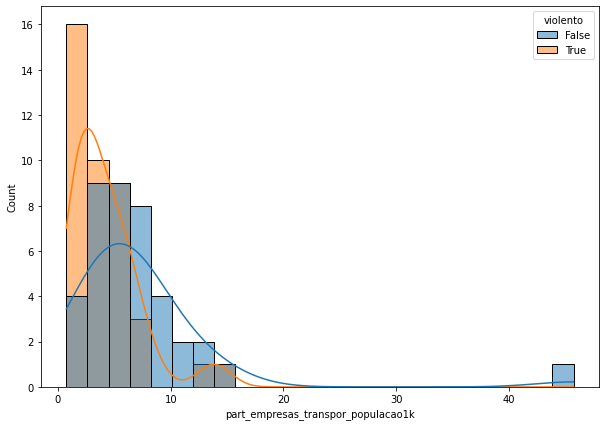

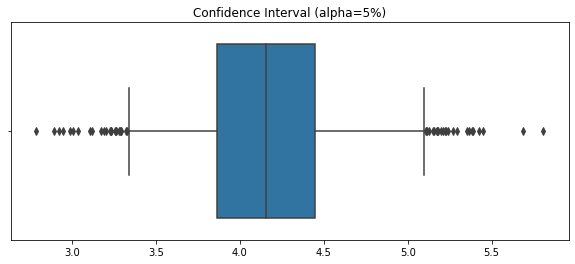

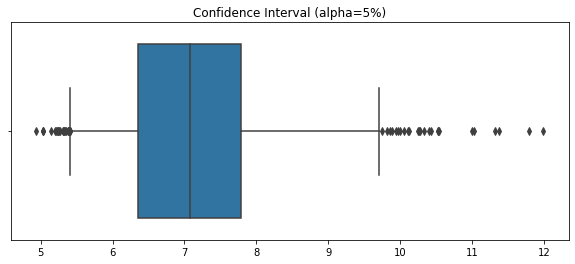

In [21]:
explainable_col = 'part_empresas_transpor_populacao1k'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença significante da quantidade de empresas da divisão econômica 'TRANSPOR' entre cidades mais/menos violentas
- Para cidades mais violentas, existem em média 4 empresas nessa divisão a cada mil hab. Varia de 3-5
- No geral existem 7 empresas nessa divisão a cada mil hab. para cidades menos violentas. Varia de 5-10, quase o **dobro em relação as cidades mais violentas**
- Obs: `transpor` == 'TRANSPORTE, ARMAZENAGEM E CORREIO'

top_municipios_mais_violentos kpis:
	avg 0.19116632020953425
	CI (0.11756245620650135, 0.2756376957216053)
top_municipios_menos_violentos kpis:
	avg 0.4265118513068309
	CI (0.29363572731779003, 0.5932044789854849)
KS-test KstestResult(statistic=0.45, pvalue=0.0005039436209702519)


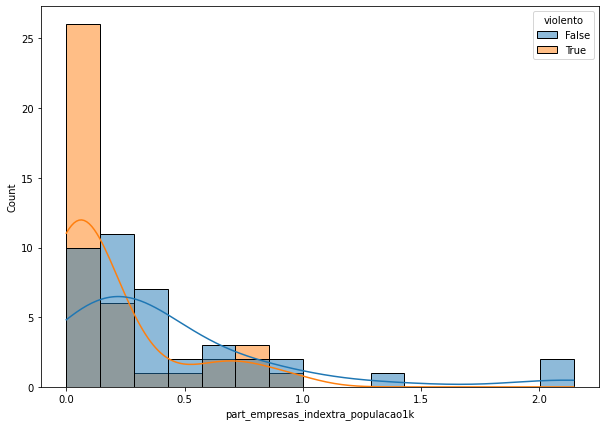

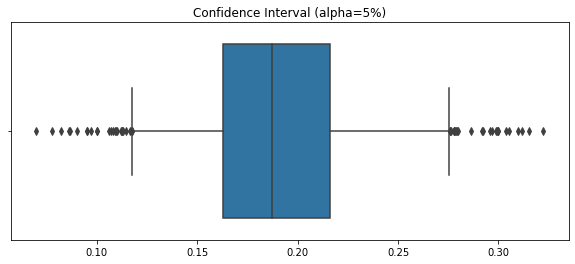

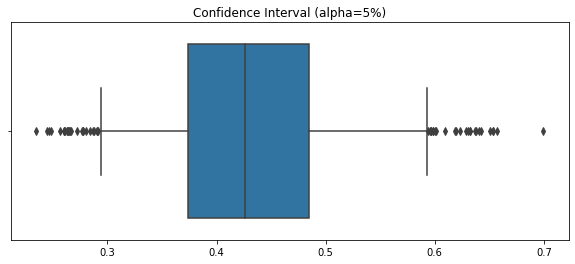

In [22]:
explainable_col = 'part_empresas_indextra_populacao1k'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Existe diferença significante da quantidade de empresas da divisão econômica 'INDEXTRA' entre cidades mais/menos violentas
- No entanto, essa diferença é baixa entre entre cidades mais/menos violentas
- Para cidades mais violentas, praticamente não existe empresas nessa divisão.
- Para cidades menos violentas, esse número pode raramente chegar 1 empresa nessa divisão a cada mil hab.
- Obs: 'INDEXTRA' == 'INDÚSTRIAS EXTRATIVAS'

top_municipios_mais_violentos kpis:
	avg 2.397165401438621
	CI (2.0647054856415545, 2.755393216779761)
top_municipios_menos_violentos kpis:
	avg 2.2798158980436476
	CI (1.7474119085576933, 2.975749536766063)
KS-test KstestResult(statistic=0.2, pvalue=0.404587405685253)


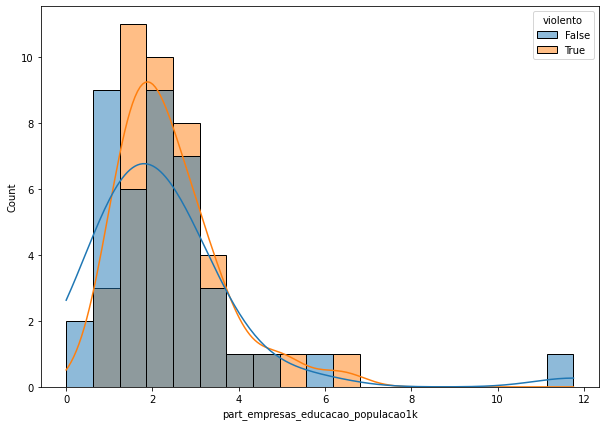

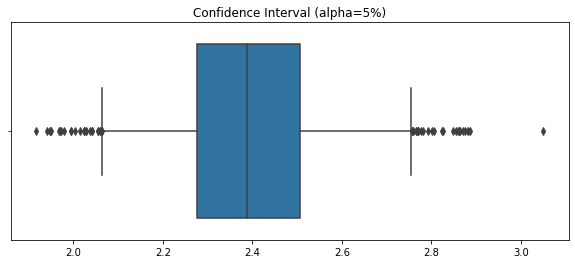

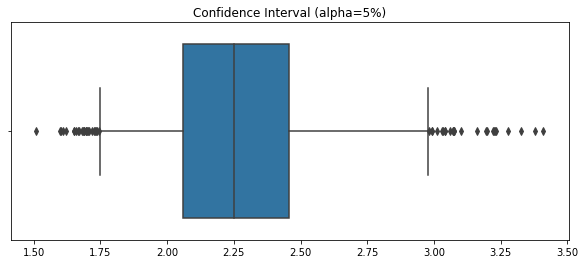

In [23]:
explainable_col = 'part_empresas_educacao_populacao1k'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

# educacao privada nao impacta na taxa de violencia

- Não existe diferença significante da quantidade de empresas da divisão econômica 'EDUCACAO' entre cidades mais/menos violentas
- No geral, existem 2 empresas nessa divisão para mil habitantes.
- Aparentemente, **educação privada não impacta na taxa de homicídios**
- Obs: 'EDUCAÇÃO' == 'EDUCACAO'

**Existe diferença na taxa de rendimento de estudantes ensino fundamental (aprov/reprov/abandono) entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 84.45250000000001
	CI (82.62374999999997, 86.39006249999996)
top_municipios_menos_violentos kpis:
	avg 86.34
	CI (83.94000000000003, 88.91012500000001)
KS-test KstestResult(statistic=0.25, pvalue=0.16497269950224194)


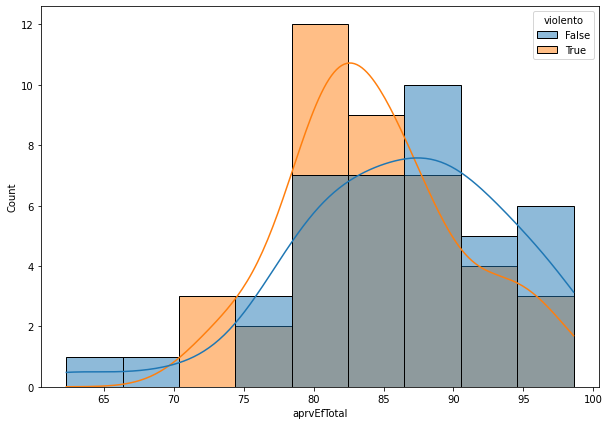

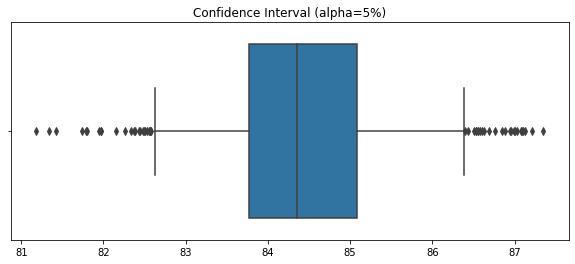

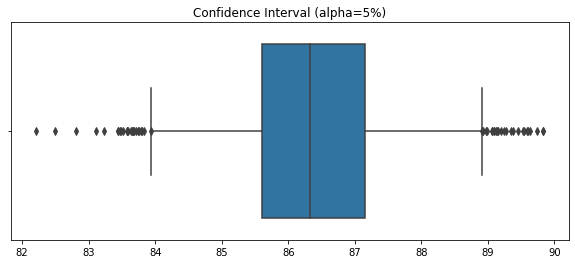

In [24]:
explainable_col = 'aprvEfTotal'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- **Não existe diferença significante da taxa de aprovação de alunos do ensino fundamental** (escola pública) entre cidades mais/menos violentas

top_municipios_mais_violentos kpis:
	avg 3.4249999999999994
	CI (2.794625, 4.11525)
top_municipios_menos_violentos kpis:
	avg 2.5649999999999995
	CI (1.97975, 3.145125)
KS-test KstestResult(statistic=0.275, pvalue=0.09707484379785862)


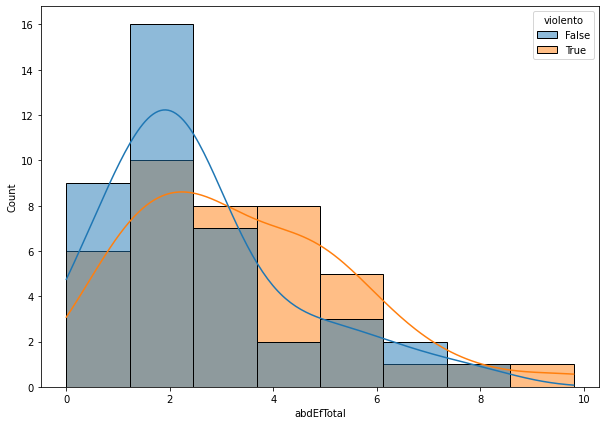

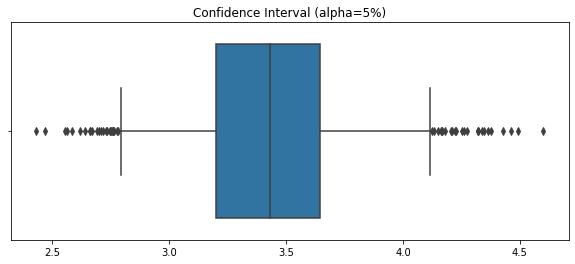

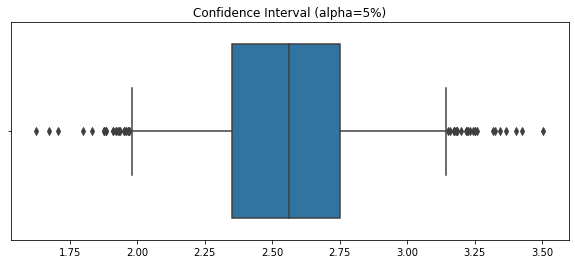

In [25]:
# taxa de abandono ensino fundamental

explainable_col = 'abdEfTotal'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- **Não existe diferença significante da taxa de abandono de alunos do ensino fundamental** (escola pública) entre cidades mais/menos violentas

**Existe diferença na taxa de rendimento de estudantes ensino médio (aprov/abandono) entre cidades mais/menos violentas?**

top_municipios_mais_violentos kpis:
	avg 74.215
	CI (68.0939375, 79.410625)
top_municipios_menos_violentos kpis:
	avg 78.39249999999998
	CI (75.20925000000001, 81.450375)
KS-test KstestResult(statistic=0.175, pvalue=0.5786001416508443)


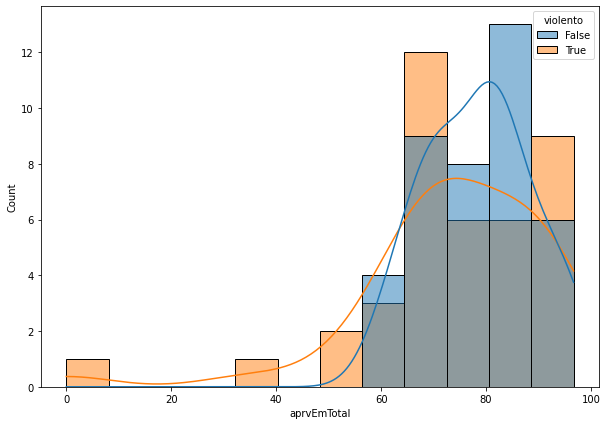

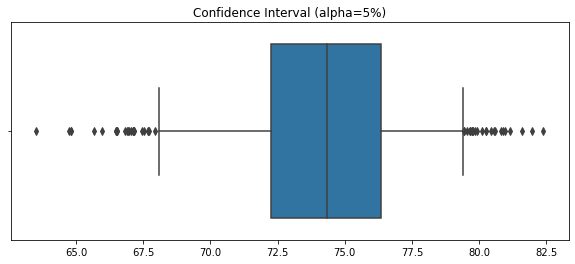

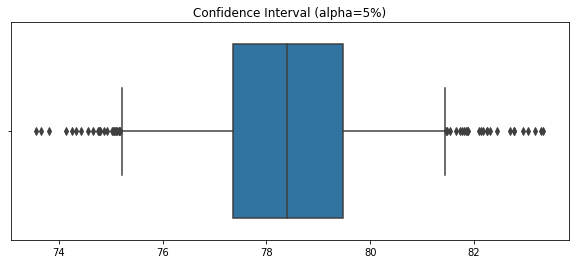

In [26]:
# taxa de aprovação ensino medio

explainable_col = 'aprvEmTotal'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- Apesar de não existir diferença significante, **existe uma diferença média de 4% de aprovação de alunos do ensino médio (pública) a favor de cidades menos violentas**
- Alunos do ensino médio em escolas púbicas de cidades menos violentas tem em média 78% de aprovação m. Varia de 75%-81%
- Em cidades menos violentas, tem 74% de aprovação. Varia de 68%-79%

top_municipios_mais_violentos kpis:
	avg 9.435000000000004
	CI (7.4499375, 11.425062500000001)
top_municipios_menos_violentos kpis:
	avg 9.837499999999997
	CI (8.169875000000001, 11.505062499999998)
KS-test KstestResult(statistic=0.15, pvalue=0.7659314523482239)


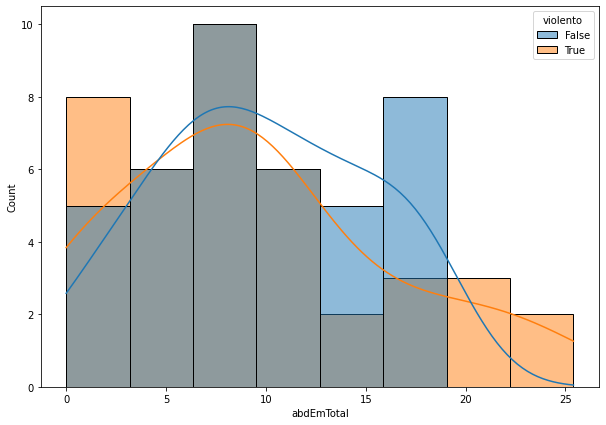

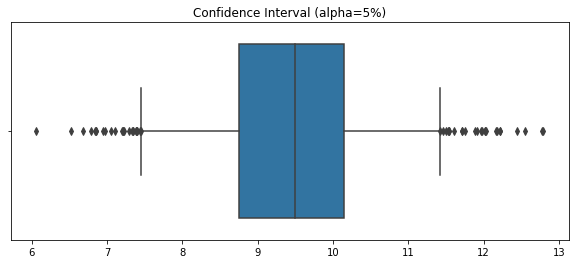

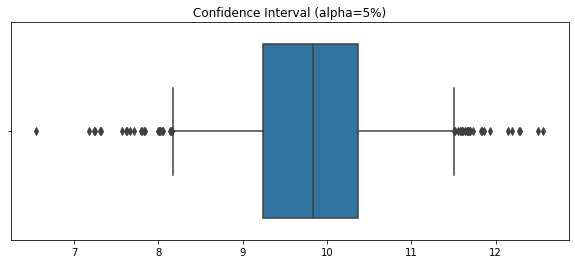

In [27]:
# taxa de abandono ensino medio

explainable_col = 'abdEmTotal'

mg.plot_hist(municipio_rotulados, explainable_col, target_variable=target_col)

print('top_municipios_mais_violentos kpis:')
print('\tavg', top_municipios_mais_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_mais_violentos[explainable_col]))

print('top_municipios_menos_violentos kpis:')
print('\tavg', top_municipios_menos_violentos[explainable_col].mean())
print('\tCI', mg.conf_interval(top_municipios_menos_violentos[explainable_col]))

print('KS-test', ks_2samp(top_municipios_mais_violentos[explainable_col], top_municipios_menos_violentos[explainable_col]))

- **Não existe diferença significante da taxa de abandono de alunos do ensino médio}** (escola pública) entre cidades mais/menos violentas

# Conclusion

- A relação entre cidades mais violentas com alta taxa de empregabilidade e nível menor de população parece ser contra-intuitivo 
- Em cidades mais violentas, as pessoas tendem a ser conhecer mais devido ao número menor da população
- Em cidades mais violentas, a população tem maior empregabilidade e, provavelmenente, mais poder de compra. Isso provavelmente chama a atenção de aproveitadores/bandidos, e, consequentemente, causar mais homicídios.
- TODO Precisamos investigar se as atividades econômicas de uma cidade influencia a violência (taxa de homicídios)
   - Quais as ocupacoes das pessoas que morreram?
   - Quais atividades economicas principais das cidades menos violentas?
   - Existe diferença de atividades economicas principais de cidades menos/mais violentas?
- TODO Outras análises também precisam ser feitas para cidades com outras faixas de população estimada
- TODO Análise global taxa de homícios nas cidades por faixa de popoulação
- OK analise correlacao
- TODO homicidios por racacor
- TODO homicidios por lococor
- TODO homicidios por nivel urbanizacao
- TODO homicidios por grupo de CID
- TODO homicidios por grupo de CBO
- TODO homicidios por grupo de CNAE
- TODO analisar dados do censo
- TODO dados mais recentes do PIB
- TODO dados mais recentes do população estimada

# Ações (TODO)

- Campanhas para fomentar empreendimentos com atividades econômicas mais relevantes para a cidade (Sebrae)
- Campanhas contra posse de arma
- Campanhas contra o racismo
- Campanhas contra o feminidicio
- Campanhas para fomentar a educação
- aumentar numero de hospitais